#Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")
warnings.resetwarnings()

#EDA

In [ ]:
df_iot = pd.read_csv('TON_IoT.csv?dl=0')

In [ ]:
unique_values = df_iot['type'].unique()
print(unique_values)

['normal' 'scanning' 'dos' 'injection' 'ddos' 'password' 'xss'
 'ransomware' 'backdoor' 'mitm']


In [ ]:
df_iot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461043 entries, 0 to 461042
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ts                      461043 non-null  int64  
 1   src_ip                  461043 non-null  object 
 2   src_port                461043 non-null  int64  
 3   dst_ip                  461043 non-null  object 
 4   dst_port                461043 non-null  int64  
 5   proto                   461043 non-null  object 
 6   service                 461043 non-null  object 
 7   duration                461043 non-null  float64
 8   src_bytes               461043 non-null  int64  
 9   dst_bytes               461043 non-null  int64  
 10  conn_state              461043 non-null  object 
 11  missed_bytes            461043 non-null  int64  
 12  src_pkts                461043 non-null  int64  
 13  src_ip_bytes            461043 non-null  int64  
 14  dst_pkts            

In [ ]:
X= df_iot.drop(['label', 'type'], axis = 1)
y= df_iot['label']

In [ ]:
le = LabelEncoder()
for col in X.columns:
    # Check if the column is of type object
    if X[col].dtype == 'object':
        # Create a LabelEncoder instance and fit-transform the column
        X[col] = le.fit_transform(X[col].astype(str))

In [ ]:
scaler = MinMaxScaler()
scaledX = scaler.fit_transform(X)

In [ ]:
num_nans = X.isna().sum().sum()
print(f'Total NaN values in df: {num_nans}')

Total NaN values in df: 0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaledX, y, test_size=0.2, random_state=20)

In [ ]:
def evaluate_classifier(y_test, y_pred):

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(set(y_test)))
    plt.xticks(tick_marks, sorted(set(y_test)))
    plt.yticks(tick_marks, sorted(set(y_test)))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add the numbers to the confusion matrix plot
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2. else 'black')

    plt.show()

    # Calculate the classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

    # Calculate sensitivity and specificity
    sensitivity = []
    specificity = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - tp - fp - fn
        sensitivity.append(tp / (tp + fn))
        specificity.append(tn / (tn + fp))
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)


# **TON-IOT**

# Hyper parameter tuning

## Snake optimization algorithm

In [ ]:
import numpy as np
from keras.layers import LSTM, Bidirectional, Dropout, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Define the Search Space
lstm_units = [32, 64, 128]
dropout_rates = [0.1, 0.2, 0.3]
learning_rates = [0.001, 0.005]
batch_sizes = [32, 64]

# Initial Random Selection from Search Space
current_hyperparameters = {
    "lstm_unit": np.random.choice(lstm_units),
    "dropout_rate": np.random.choice(dropout_rates),
    "learning_rate": np.random.choice(learning_rates),
    "batch_size": np.random.choice(batch_sizes)
}

# Store the best hyperparameters and accuracy
best_hyperparameters = None
best_accuracy = 0

# Function to train a model with given hyperparameters
def train_model(hyperparameters):
    model = Sequential()
    model.add(Bidirectional(LSTM(hyperparameters["lstm_unit"], activation='tanh', return_sequences=True), input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hyperparameters["dropout_rate"]))
    model.add(Bidirectional(LSTM(int(hyperparameters["lstm_unit"]/2), activation='tanh', return_sequences=True)))
    model.add(Dropout(hyperparameters["dropout_rate"]))
    model.add(Bidirectional(LSTM(int(hyperparameters["lstm_unit"]/4), activation='tanh')))
    model.add(Dropout(hyperparameters["dropout_rate"]))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=hyperparameters["learning_rate"])
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=5, batch_size=hyperparameters["batch_size"], validation_data=(X_test, y_test), callbacks=[early_stopping])

    return history.history["val_accuracy"][-1]

# SOA Loop
for iteration in range(10):
    accuracy = train_model(current_hyperparameters)

    # Update best hyperparameters if better ones are found
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = current_hyperparameters.copy()

        # Greedy Exploitation: Refine search around the best hyperparameters
        # Here, we're perturbing the hyperparameters slightly
        current_hyperparameters = {
            "lstm_unit": max(32, best_hyperparameters["lstm_unit"] + np.random.choice([-16, 16])),
            "dropout_rate": min(0.3, max(0.1, best_hyperparameters["dropout_rate"] + np.random.choice([-0.1, 0.1]))),
            "learning_rate": min(0.005, max(0.001, best_hyperparameters["learning_rate"] * np.random.choice([0.5, 1.5]))),
            "batch_size": max(32, best_hyperparameters["batch_size"] + np.random.choice([-16, 16]))
        }
    else:
        # Random Exploration
        current_hyperparameters = {
            "lstm_unit": np.random.choice(lstm_units),
            "dropout_rate": np.random.choice(dropout_rates),
            "learning_rate": np.random.choice(learning_rates),
            "batch_size": np.random.choice(batch_sizes)
        }

print("Best Hyperparameters:", best_hyperparameters)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
5764/5764 [==============================] - 117s 18ms/step - loss: 0.1946 - accuracy: 0.9190 - val_loss: 0.1004 - val_accuracy: 0.9617
Epoch 2/5
5764/5764 [==============================] - 100s 17ms/step - loss: 0.0855 - accuracy: 0.9676 - val_loss: 0.0615 - val_accuracy: 0.9743
Epoch 3/5
5764/5764 [==============================] - 100s 17ms/step - loss: 0.0512 - accuracy: 0.9818 - val_loss: 0.0315 - val_accuracy: 0.9898
Epoch 4/5
5764/5764 [==============================] - 98s 17ms/step - loss: 0.0350 - accuracy: 0.9881 - val_loss: 0.0231 - val_accuracy: 0.9914
Epoch 5/5
5764/5764 [==============================] - 99s 17ms/step - loss: 0.0271 - accuracy: 0.9905 - val_loss: 0.0178 - val_accuracy: 0.9936
Epoch 1/5
4611/4611 [==============================] - 95s 19ms/step - loss: 0.1734 - accuracy: 0.9270 - val_loss: 0.0815 - val_accuracy: 0.9670
Epoch 2/5
4611/4611 [==============================] - 88s 19ms/step - loss: 0.0669 - accuracy: 0.9734 - val_loss: 0.0573 - val

In [ ]:
print('best acc', best_accuracy)

best acc 0.9947184920310974


## training with best parameters

In [ ]:
from keras.layers import LSTM, Bidirectional, Dropout, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Bidirectional(LSTM(144, activation='tanh', return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(int(144/2), activation='tanh', return_sequences=True)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(int(144/4), activation='tanh')))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

opt = Adam(lr=0.0015)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=5, batch_size=80, validation_data=(X_test, y_test), callbacks=[early_stopping])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
4611/4611 [==============================] - 103s 19ms/step - loss: 0.2129 - accuracy: 0.9108 - val_loss: 0.1004 - val_accuracy: 0.9580
Epoch 2/5
4611/4611 [==============================] - 97s 21ms/step - loss: 0.0830 - accuracy: 0.9671 - val_loss: 0.0426 - val_accuracy: 0.9838
Epoch 3/5
4611/4611 [==============================] - 85s 19ms/step - loss: 0.0599 - accuracy: 0.9763 - val_loss: 0.0502 - val_accuracy: 0.9792
Epoch 4/5
4611/4611 [==============================] - 84s 18ms/step - loss: 0.0532 - accuracy: 0.9799 - val_loss: 0.0718 - val_accuracy: 0.9773
Epoch 5/5
4611/4611 [==============================] - 82s 18ms/step - loss: 0.0452 - accuracy: 0.9832 - val_loss: 0.0349 - val_accuracy: 0.9879


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert predicted probabilities to binary labels

Confusion Matrix:
[[59226   694]
 [  421 31868]]


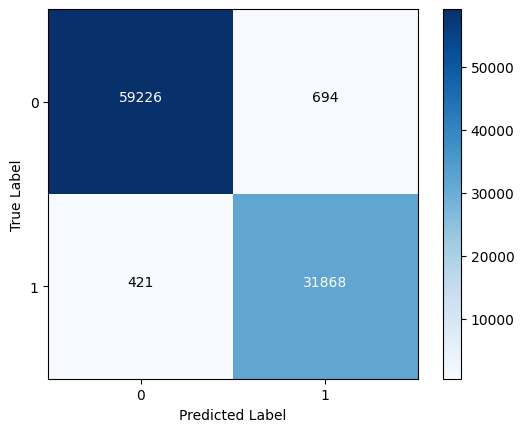

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59920
           1       0.98      0.99      0.98     32289

    accuracy                           0.99     92209
   macro avg       0.99      0.99      0.99     92209
weighted avg       0.99      0.99      0.99     92209

Sensitivity: [0.9884178905206943, 0.9869615039177428]
Specificity: [0.9869615039177428, 0.9884178905206943]


In [ ]:
evaluate_classifier(y_test, y_pred)

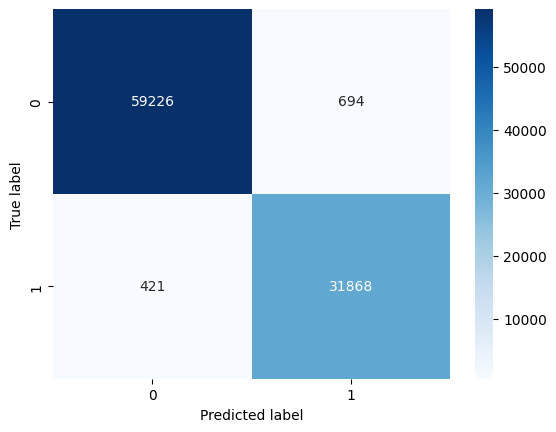

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59920
           1       0.98      0.99      0.98     32289

    accuracy                           0.99     92209
   macro avg       0.99      0.99      0.99     92209
weighted avg       0.99      0.99      0.99     92209



In [ ]:
e